### Importing all necessary libraries

In [1]:
import numpy as np
import tensorflow as tf
from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D
from keras.models import Model
import os
import numpy as np
import pandas as pd
from pyntcloud import PyntCloud
import open3d as o3d
from ConversionUtils import ConversionUtils
from Visualization import Visualization

2023-10-19 14:46:28.181450: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-19 14:46:28.181527: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-19 14:46:28.186753: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-19 14:46:29.301613: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Converting STL to point cloud
**Only execute the next cell if the point cloud files do not exist in abc-dataset-ply/ directory**

In [10]:
files = sorted(ConversionUtils.list_files_in_directory("abc-dataset-stl/"))
for i in files:
    path = "abc-dataset-stl/" + i
    ConversionUtils.stl_to_ply(path)

### Converting point cloud to binary voxel arrays

In [2]:
directory = "abc-dataset-ply/"
files = sorted([filename for filename in os.listdir(directory) if os.path.isfile(os.path.join(directory, filename))])
dataset = []

for i in files:
    path = os.path.join(directory, i)
    binvox = ConversionUtils.convert_to_binvox(path)
    dataset.append(binvox)

### Splitting dataset for training and testing

In [3]:
# Load your dataset into numpy arrays
dataset = np.array(dataset)

# Split your dataset into train and test datasets
train_dataset = dataset[:320]  # Adjust the number as needed
test_dataset = dataset[320:]   # The remaining data for testing

# Define the input shape
input_shape = (64, 64, 64, 1)

### Encoder

In [4]:
input_data = Input(shape=input_shape)
x = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(input_data)
x = MaxPooling3D((2, 2, 2), padding='same')(x)
x = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling3D((2, 2, 2), padding='same')(x)

2023-10-19 14:46:55.012522: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-19 14:46:55.733243: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-19 14:46:55.733881: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### Decoder

In [5]:
x = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(encoded)
x = UpSampling3D((2, 2, 2))(x)
x = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(x)
x = UpSampling3D((2, 2, 2))(x)
decoded = Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same')(x)

### Training autoencoder, prediction done on test dataset

In [6]:
autoencoder = Model(input_data, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(train_dataset, train_dataset, epochs=40, batch_size=10, validation_data=(test_dataset, test_dataset))
reconstructed_data = autoencoder.predict(test_dataset)

Epoch 1/40


2023-10-19 14:50:56.431049: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-19 14:51:05.759273: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f6d35880be0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-19 14:51:05.759310: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2023-10-19 14:51:05.879654: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-19 14:51:06.509755: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 [==============================] - 23s 308ms/step - loss: 0.2418 - val_loss: 0.0423
Epoch 2/40
32/32 [==============================] - 9s 294ms/step - loss: 0.0504 - val_loss: 0.0362
Epoch 3/40
32/32 [==============================] - 9s 295ms/step - loss: 0.0454 - val_loss: 0.0333
Epoch 4/40
32/32 [==============================] - 9s 296ms/step - loss: 0.0430 - val_loss: 0.0318
Epoch 5/40
32/32 [==============================] - 9s 296ms/step - loss: 0.0415 - val_loss: 0.0306
Epoch 6/40
32/32 [==============================] - 9s 297ms/step - loss: 0.0401 - val_loss: 0.0293
Epoch 7/40
32/32 [==============================] - 9s 297ms/step - loss: 0.0389 - val_loss: 0.0284
Epoch 8/40
32/32 [==============================] - 10s 298ms/step - loss: 0.0376 - val_loss: 0.0273
Epoch 9/40
32/32 [==============================] - 9s 298ms/step - loss: 0.0365 - val_loss: 0.0262
Epoch 10/40
32/32 [==============================] - 10s 299ms/step - loss: 0.0356 - val_loss: 0.0256
Epoch 1

### Sample reconstruction from test dataset

In [8]:
import matplotlib.pyplot as plt

index = 17

original_sample = test_dataset[index]

reconstructed_sample = reconstructed_data[index].reshape(64, 64, 64)
threshold = 0.35
reconstructed_sample = (reconstructed_sample > threshold).astype(int)

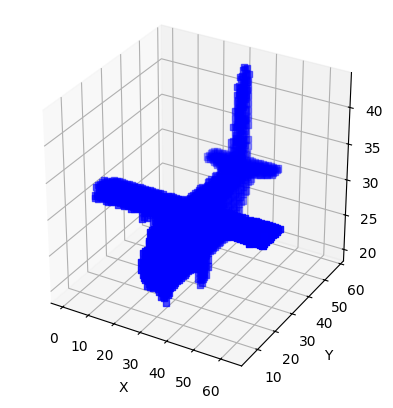

In [9]:
Visualization.matplotlib_visualize_original(original_sample)

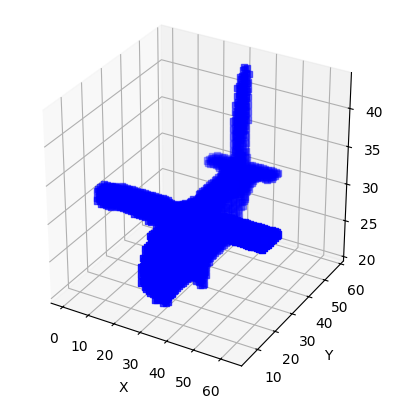

In [10]:
Visualization.matplotlib_visualize_reconstructed(reconstructed_sample)

In [23]:
Visualization.open3d_visualize_original(original_sample)

In [24]:
Visualization.open3d_visualize_reconstructed(reconstructed_sample)